In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
import sys
sys.path.append('/home/njr61/rds/hpc-work/spurious-concepts/ConceptBottleneck')

In [4]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2

In [5]:
from ConceptBottleneck.CUB.models import ModelXtoC, ModelOracleCtoY
from ConceptBottleneck.CUB.dataset import load_data

In [68]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Set up dataset + model

In [8]:
dataset_name = "synthetic_2"
data_dir = "../cem/cem/{}/preprocessed/".format(dataset_name)
num_attributes = 1
num_classes = 1

In [9]:
concept_combinations = [
    [1,0,1,0],
    [0,1,0,1],
    [1,0,0,1],
    [0,1,1,0],
]
concept_y = [
    0,1,1,1
]

In [10]:
train_data_path = os.path.join(data_dir, 'train.pkl')
val_data_path = train_data_path.replace('train.pkl', 'val.pkl')

In [11]:
pretrained = True
freeze = False
use_aux = True
expand_dim = 0
three_class = False
use_attr = True
no_img = False
batch_size = 64
uncertain_labels = False
image_dir = 'images'
num_class_attr = 2
resampling = False

In [12]:
train_loader = load_data([train_data_path], use_attr, no_img, batch_size, uncertain_labels, image_dir=image_dir, 
                         n_class_attr=num_class_attr, resampling=resampling, path_transform=lambda path: "../cem/cem/"+path, is_training=False)
val_loader = load_data([val_data_path], use_attr, no_img=False, batch_size=64, image_dir=image_dir, n_class_attr=num_class_attr, path_transform=lambda path: "../cem/cem/"+path)

In [13]:
joint_location = "ConceptBottleneck/results/{}/joint/best_model_42.pth".format(dataset_name)
joint_model = torch.load(joint_location,map_location=torch.device('cpu'))
r = joint_model.eval()

## Plot the Dataset

In [14]:
train_pkl = pickle.load(open(train_data_path,"rb"))
val_pkl = pickle.load(open(val_data_path,"rb"))

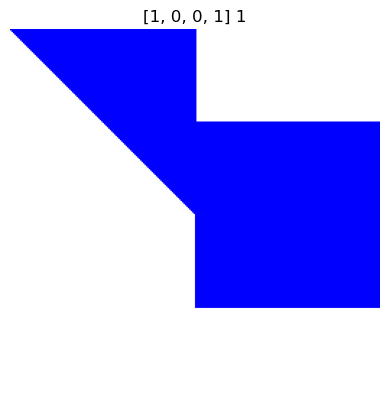

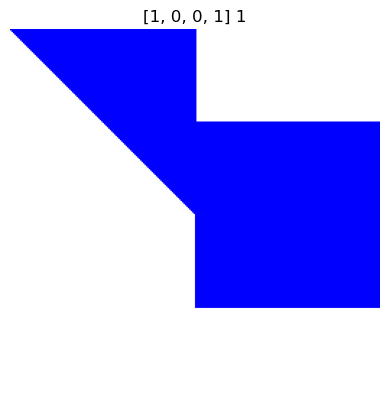

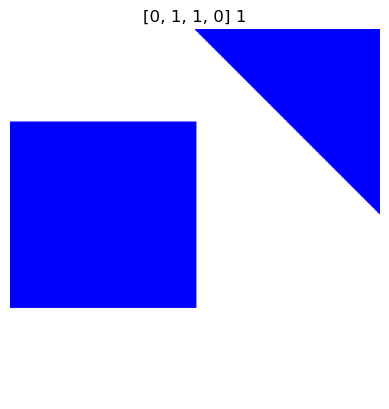

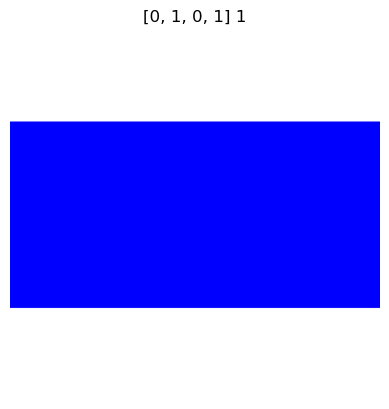

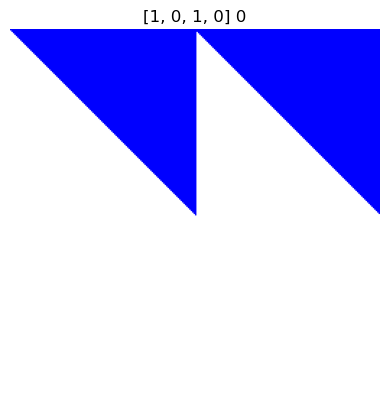

In [15]:
num_images_show = 5
for i in range(num_images_show):
    img_path = '../cem/cem/'+train_pkl[i]['img_path']
    image = Image.open(img_path)
    image_array = np.array(image)
    plt.figure()
    plt.imshow(image_array)
    plt.axis('off') 
    plt.title(str(train_pkl[i]['attribute_label']) + ' '+str(train_pkl[i]['class_label']))

## Analyze Accuracy

In [16]:
get_accuracy(joint_model,run_joint_model,train_loader), get_accuracy(joint_model,run_joint_model,val_loader)

(tensor(1.), tensor(1.))

In [17]:
get_concept_accuracy(joint_model,run_joint_model,train_loader,sigmoid=True)

(0.08040642365813255, 0.865234375)

## Analyze Concept-Task Relationships

In [18]:
val_images = []
val_y = []
val_c = []
for batch in val_loader:
    x, y, c = batch  
    val_images.append(x)
    val_y.append(y)
    val_c.append(torch.stack(c).T)
val_images = torch.cat(val_images, dim=0)
val_y = torch.cat(val_y,dim=0)
val_c = torch.cat(val_c,dim=0)

In [19]:
attribute_weights, y_pred, c_pred = get_attribute_class_weights(
    joint_model,run_joint_model,joint_model.sec_model.linear.weight,val_images)

In [20]:
attributes = ['left_triangle','left_square','right_triangle','right_square']

In [21]:
attribute_weights[:2,:,0]

tensor([[  2.2430, -13.5272,  -2.0122,  -4.9773],
        [ -2.4773,  11.3592,   2.5971,   4.2953]], grad_fn=<SelectBackward0>)

[1.9259839057922363, 1.2145264148712158, 0.8787963390350342, 0.5405023694038391] ['right_tria (#2)', 'left_trian (#0)', 'right_squa (#3)', 'left_squar (#1)']


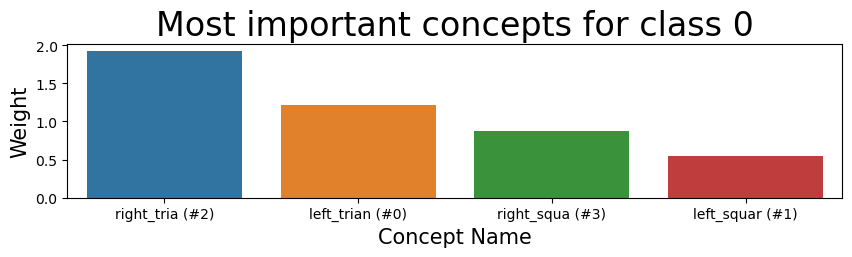

In [22]:
plt.figure(figsize=(10,2))
plt.title("Most important concepts for class 0",fontsize=24)
plt.xlabel("Concept Name",fontsize=15)
plt.ylabel("Weight",fontsize=15)
plot_most_important_classes(attribute_weights,attributes,0)

[-0.4538739323616028, -0.7583818435668945, -1.3413807153701782, -2.4857213497161865] ['left_squar (#1)', 'right_squa (#3)', 'left_trian (#0)', 'right_tria (#2)']


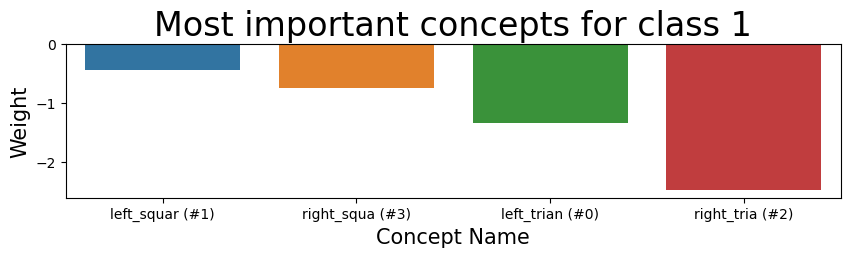

In [23]:
plt.figure(figsize=(10,2))
plt.title("Most important concepts for class 1",fontsize=24)
plt.xlabel("Concept Name",fontsize=15)
plt.ylabel("Weight",fontsize=15)
plot_most_important_classes(attribute_weights,attributes,1)

In [24]:
y_pred == joint_model.sec_model.forward(torch.nn.Sigmoid()(c_pred.T))

tensor([[True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [T

### Impact of Each concept combination on task

In [25]:
for concept_combo, true_class in zip(concept_combinations,concept_y):
    predicted_result = joint_model.sec_model.forward(torch.Tensor([concept_combo]))
    predicted_class = torch.argmax(predicted_result[0])
    print("Predicted class {}, true class {}".format(predicted_class,true_class))

Predicted class 0, true class 0
Predicted class 1, true class 1
Predicted class 1, true class 1
Predicted class 1, true class 1


## Analyze Concept-Input Relationships

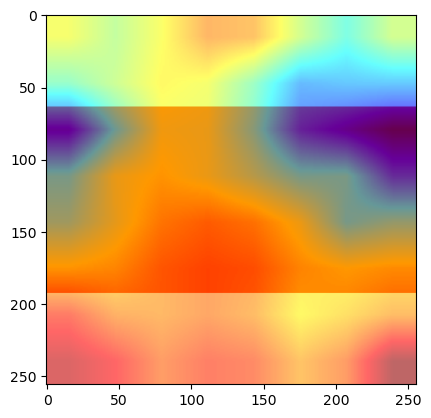

In [86]:
plot_gradcam(joint_model,run_joint_model,0,val_images,0,val_pkl)

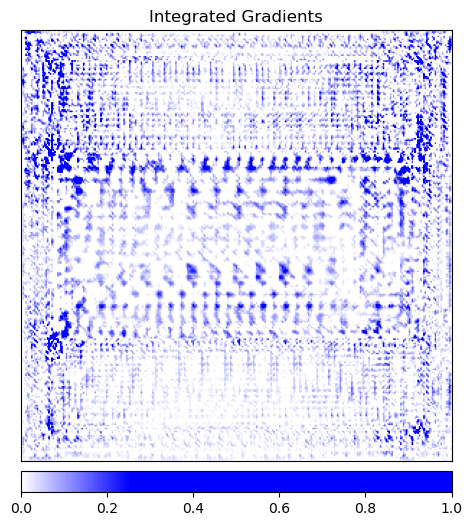

In [128]:
plot_integrated_gradients(joint_model,run_joint_model,0,val_images,0)

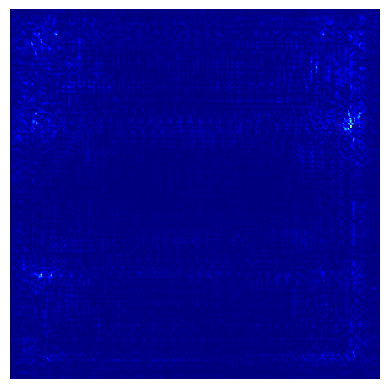

In [25]:
plot_saliency(joint_model,run_joint_model,0,val_images,0)

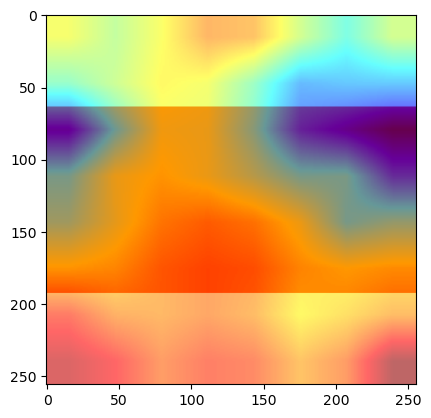

In [90]:
plot_gradcam(joint_model,run_joint_model,0,val_images,2,val_pkl)

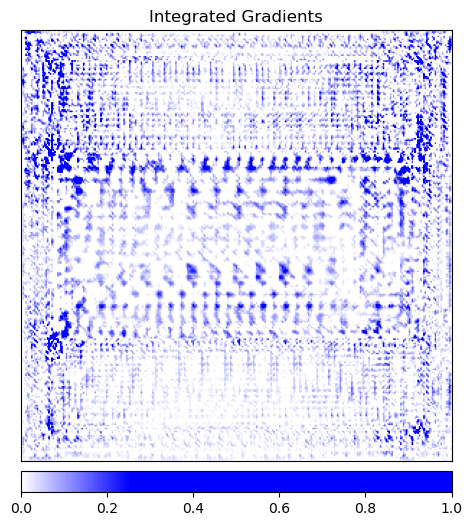

In [92]:
plot_integrated_gradients(joint_model,run_joint_model,0,val_images,2)

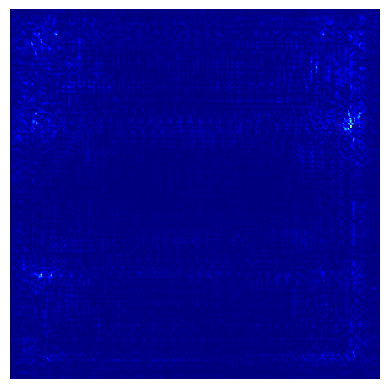

In [56]:
plot_saliency(joint_model,run_joint_model,0,val_images,2)

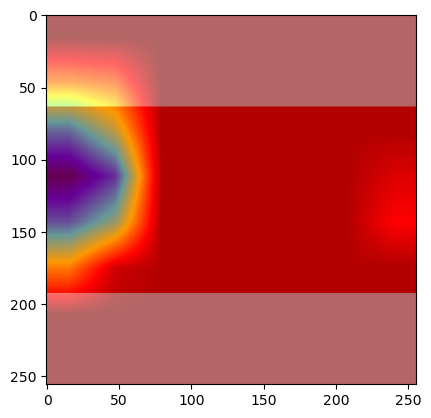

In [91]:
plot_gradcam(joint_model,run_joint_model,2,val_images,0,val_pkl)

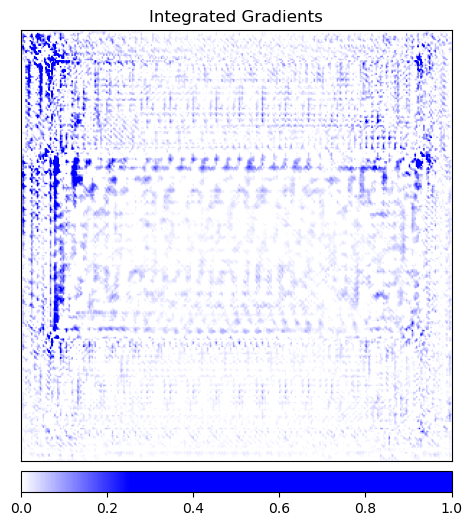

In [93]:
plot_integrated_gradients(joint_model,run_joint_model,2,val_images,0)

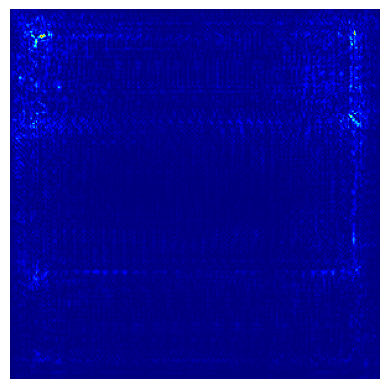

In [57]:
plot_saliency(joint_model,run_joint_model,2,val_images,0)